In [1]:
#  displays plots directly in this notebook as images
%matplotlib inline
import numpy as np       # the NumPy library for fast matrix and vector data types and math operations
import matplotlib.pyplot as plt   # functions for plotting, loaded under a convenient name alias 'plt'
import xarray as xr      # matrix and vector containers with labeled axes, used for signals
import holoviews as hv   # a different plotting web-based library mainly for interactive display
import hvplot.xarray     # xaray wrappers for holoviews
import xrscipy           # additional SciPy xarray-compatible wrappers
import xrscipy.signal as dsp    # subpackage convenience: functions for digital signal processing of signals
import xrrandom          # for random sammpling parametrized by xarray objects
import cdb_extras.xarray_support as cdbxr  # a convenient Python library for accessing the COMPASS database

In [109]:
from scipy.signal import savgol_filter

def plot_signals(n_shot, start=0, end=2000):

    shot = cdbxr.Shot(n_shot)
    
    signal_APD = shot['APD.light_profile'].sel(time=slice(start, end)).data[:,14]
    time_APD = shot['APD.light_profile'].sel(time=slice(start, end)).time

    signal_Mirnov = shot.Mirnov_A_rad_02_RAW.sel(time=slice(start, end)).data
    time_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(start, end)).time
    
    plt.plot(time_Mirnov, signal_Mirnov, c='r')
    
    signal_APD -= savgol_filter(signal_APD, 51, 4)
    signal_Mirnov -= savgol_filter(signal_Mirnov, 51, 4)
    
    
    plt.plot(time_Mirnov, signal_Mirnov, c='b', label='Mirnov')
    #plt.plot(time_APD, signal_APD, c='g', label='APD_')
    
    plt.legend()
    
    
# these two time series are not defined on the same time points. We obtain this by averaging!
def time_series_average(time_arr, signal_arr, time_step, start, end):

    assert len(time_arr) == len(signal_arr)
    assert len(time_arr) > (end - start) / time_step, 'too short time_step!'
    
    time = np.arange(start, end-time_step, time_step)
    
    # optimize this?
    signal_ave = np.array([signal_arr[(t<=time_arr)&(time_arr<t+time_step)].mean() for t in time])
    time += time_step / 2
    
    return time, signal_ave


def plot_signals_averaged(n_shot, start=0, end=2000, dt=None):

    shot = cdbxr.Shot(n_shot)
    
    signal_APD = shot['APD.light_profile'].sel(time=slice(start, end)).data[:,14]
    time_APD = shot['APD.light_profile'].sel(time=slice(start, end)).time
    
    signal_Mirnov = shot.Mirnov_A_rad_02_RAW.sel(time=slice(start, end)).data
    time_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(start, end)).time

    dt_min = max(np.diff(time_APD).max(), np.diff(time_Mirnov).max())
    if dt is None:
        dt = dt_min
    elif dt < dt_min:
        dt = dt_min
        import warnings
        warnings.warn('time step too small, set to minimum value')
        
        
    t_APD, s_APD = time_series_average(time_APD, signal_APD, dt, start, end)
    t_Mirnov, s_Mirnov = time_series_average(time_Mirnov, signal_Mirnov, dt, start, end)
    
    plt.plot(t_Mirnov, s_Mirnov, c='b', label='Mirnov')
    plt.plot(t_APD, s_APD, c='g', label='APD')
    
    plt.legend()

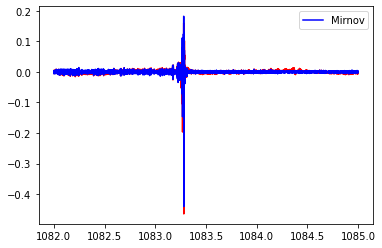

In [110]:
plot_signals(17269, start=1082, end=1085)

In [117]:
# Code from previous year, sent to us by Miklós

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import AR, AutoReg, ar_select_order

def get_gcc(x, y, d=3):
    """Computes F value wether y Granger causes x

    :param numpy.ndarray x: target array shape (1D)
    :param numpy.ndarray y: source array (1D)
    :param int d: maxlag of autoregression
    :return: log(F) value for y -> x
    :rtype: float

    """
    # for definition of AR => (https://en.wikipedia.org/wiki/Autoregressive_model#Definition)
    
    #mod = ar_select_order(x, maxlag=d) # chooses optimal 
    ar = AR(x).fit(maxlags=d)
    #if not list(mod.ar_lags):
    #    ar = AutoReg(x, lags=2).fit()
    #else:
    #    ar = AutoReg(x, lags=mod.ar_lags).fit()
    
    
    var = VAR(np.array([x, y]).T).fit(maxlags=d)
  
    return np.log(ar.resid.var() / var.resid.var(axis=0)[0])

In [38]:
mod.ar_lags

NameError: name 'mod' is not defined

In [111]:
from scipy.signal import savgol_filter, detrend

def plot_gcc(n_shot, start=0, end=2000, dt=None, r_apd=14, window=3, d=15):
    assert window % 2 == 1, 'window must be odd!'
    assert isinstance(window, int)
    
    shot = cdbxr.Shot(n_shot)
    
    signal_APD = shot['APD.light_profile'].sel(time=slice(start, end)).data[:,r_apd]
    signal_APD /= signal_APD.max()
    time_APD = shot['APD.light_profile'].sel(time=slice(start, end)).time
    signal_APD = detrend(signal_APD, type='constant')
    
    
    signal_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(start, end)).data
    signal_Mirnov /= signal_Mirnov.max()
    time_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(start, end)).time
    signal_Mirnov = detrend(signal_Mirnov, type='constant')
    
    signal_APD -= savgol_filter(signal_APD, 51, 4)
    signal_Mirnov -= savgol_filter(signal_Mirnov, 51, 4)
    
    dt_min = max(np.diff(time_APD).max(), np.diff(time_Mirnov).max())
    if dt is None:
        dt = dt_min
    elif dt < dt_min:
        dt = dt_min
        print(f'time step too small, set to minimum value dt={dt_min}')

    t_APD, s_APD = time_series_average(time_APD, signal_APD, dt, start, end)
    t_Mirnov, s_Mirnov = time_series_average(time_Mirnov, signal_Mirnov, dt, start, end)
    
    assert np.array_equal(t_APD, t_Mirnov)
    
    
    t_gcc = np.zeros(t_APD.size - window + 1)
    sxy_gcc = np.zeros(t_gcc.shape)
    syx_gcc = np.zeros(t_gcc.shape)
    
    for i, _ in enumerate(t_gcc):
        t_gcc[i] = t_APD[i+int((window-1)/2)]
        
        x = s_APD[i:i+window]
        y = s_Mirnov[i:i+window]
        
        sxy_gcc[i] = get_gcc(x, y)
        syx_gcc[i] = get_gcc(y, x)
        
    plt.figure(figsize=(20, 10))
    plt.plot(t_gcc, sxy_gcc, c='k', label='GCC Mirnov->APD')
    plt.plot(t_gcc, syx_gcc, 'k--', label='GCC APD->Mirnov')
    plt.plot(t_APD, savgol_filter(s_APD, 31, 3), c='r', alpha=.6, label='APD')
    plt.plot(t_Mirnov, s_Mirnov, c='b', alpha=.6, label='Mirnov')
    plt.legend()

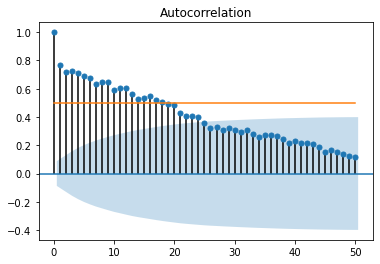

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

shot = cdbxr.Shot(18447)
signal_APD = shot['APD.light_profile'].sel(time=slice(1112.5, 1115)).data[:,14]
signal_APD = detrend(signal_APD)
    
plot_acf(signal_APD, lags=50)
plt.plot([0, 50], [.5, .5])
plt.show()

/sw/python/3.8-anaconda-2020.07/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, F

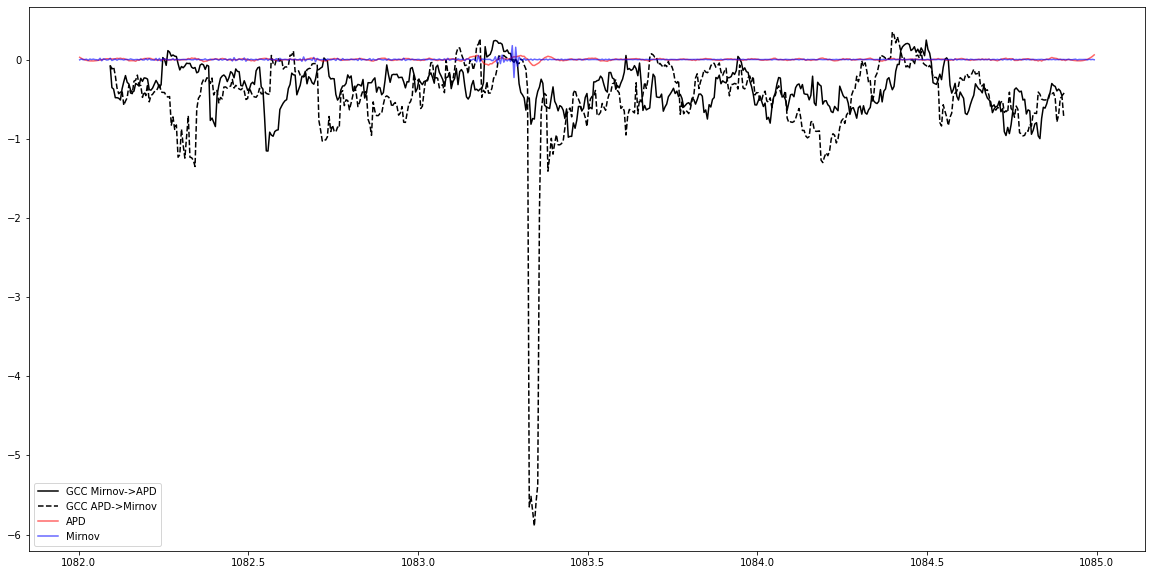

In [119]:
plot_gcc(17269, start=1082, end=1085, window=37)

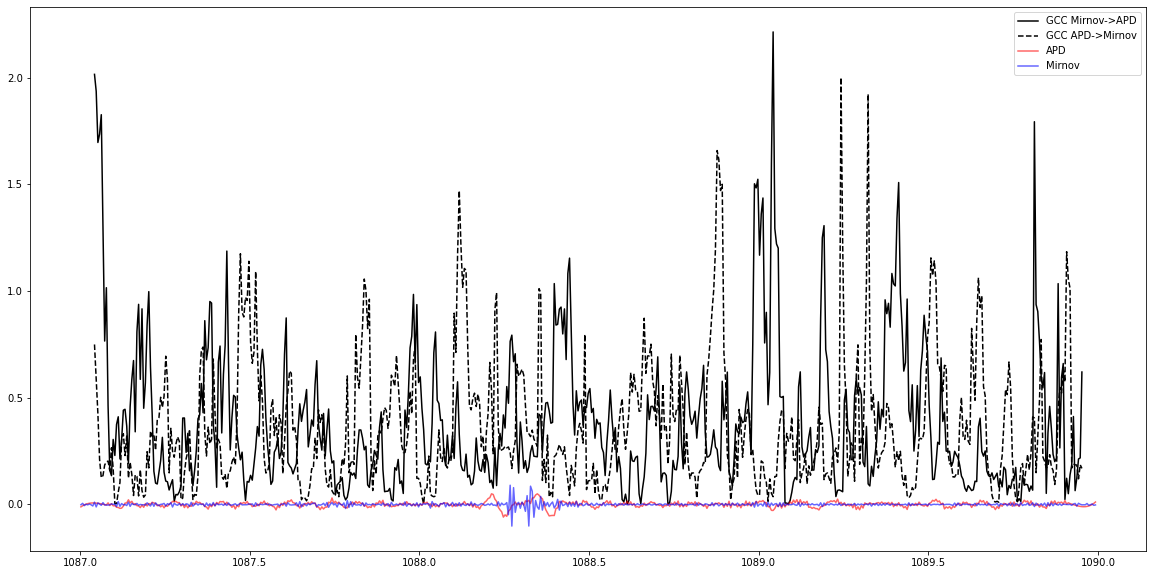

In [115]:
plot_gcc(17269, start=1087, end=1090, window=17)

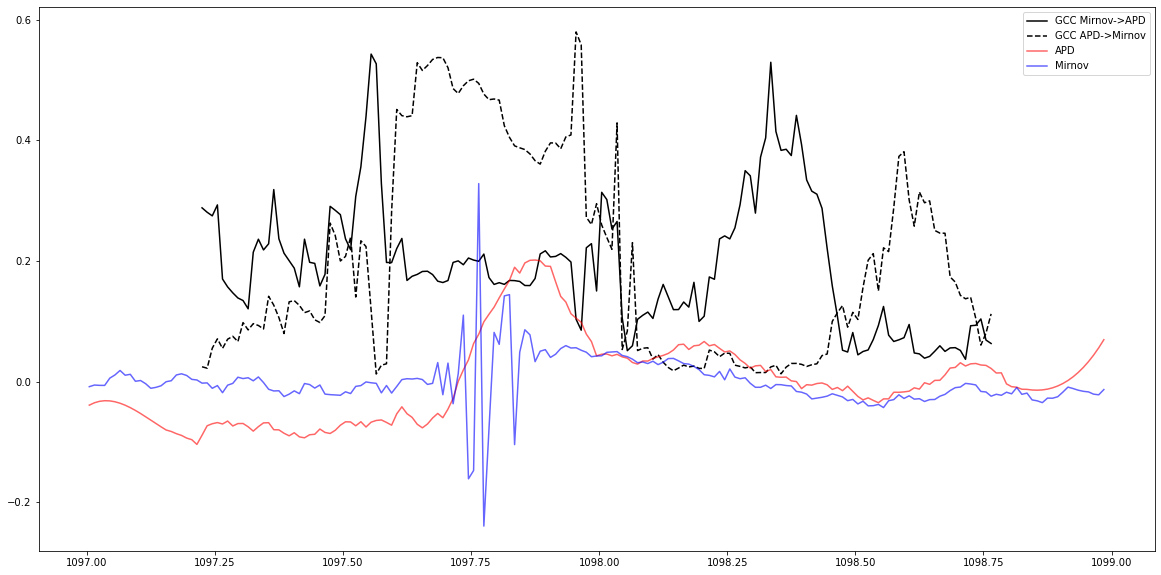

In [103]:
plot_gcc(17229, start=1097, end=1099, window=45, r_apd=12)

## NEW TRY

In [72]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cdb_extras.xarray_support as cdbxr  # a convenient Python library for accessing the COMPASS database
from scipy.signal import savgol_filter, detrend

In [77]:
# Constants
N_SHOT = 17269
T_START = 1087
T_END = 1090

CHANNEL_APD = 14

WINDOW = 51

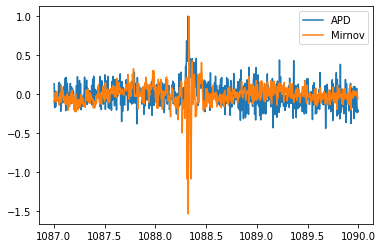

In [104]:
# Load the relevant signals
shot = cdbxr.Shot(N_SHOT)

# APD processed data
s_APD = detrend(shot['APD.light_profile'].sel(time=slice(T_START, T_END)).isel(R=CHANNEL_APD).data, type='constant')
t_APD = shot['APD.light_profile'].sel(time=slice(T_START, T_END)).time

# Raw Mirnov coil data (2nd radially, it's closest to the Li-beam)
s_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(T_START, T_END)).data[:-1:10] # every 10th data point!
t_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(T_START, T_END)).time[:-1:10]

# Normalize data
s_APD /= s_APD.max()
s_Mirnov /= s_Mirnov.max()

plt.plot(t_APD, s_APD, label='APD')
plt.plot(t_Mirnov, s_Mirnov, label='Mirnov')
plt.legend()
plt.show()

# Processing before comparison of signals
The two signals have different sample frequencies and in order to compare the two, this need to be taken care of. APD signal has the frequrncy of  Prior to this I've used a timestep-averaging, which may have been causing the problems with the GCC plots.

Since the frequencies are 200 kHz (APD) and 2000 kHz (Mirnov), I'll will try here to take only every 10th data point from the Mirnov coil signal.

#### OBS. THEY DO NOT EXACTLY MATCH IN TIME, SO PERHAPS TRY LINEAR INTERPOLATION IN MIRNOV SIGNAL!!!

(1087.0, 1087.1)

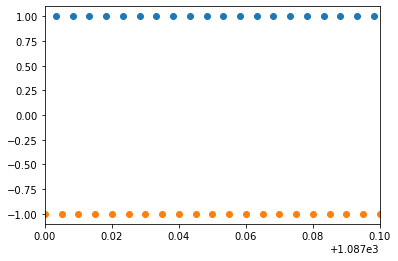

In [39]:
plt.scatter(t_APD, np.ones(t_APD.shape))
plt.scatter(t_Mirnov, -np.ones(t_Mirnov.shape))
plt.xlim(T_START, T_START + 1e-1)

In [83]:
# Code from previous year, sent to us by Miklós
import warnings
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import AR

def get_gcc(x, y, d=5):
    """Computes F value wether y Granger causes x

    :param numpy.ndarray x: target array shape (1D)
    :param numpy.ndarray y: source array (1D)
    :param int d: maxlag of autoregression
    :return: log(F) value for y -> x
    :rtype: float

    """
    warnings.simplefilter("ignore")
    
    # for definition of AR => (https://en.wikipedia.org/wiki/Autoregressive_model#Definition)
    ar = AR(x)
    ar_fit = ar.fit(maxlag=d)
    var = VAR(np.array([x, y]).T)
    var_fit = var.fit(maxlags=d)
   
  
    return np.log(ar_fit.resid.var() / var_fit.resid.var(axis=0)[0])

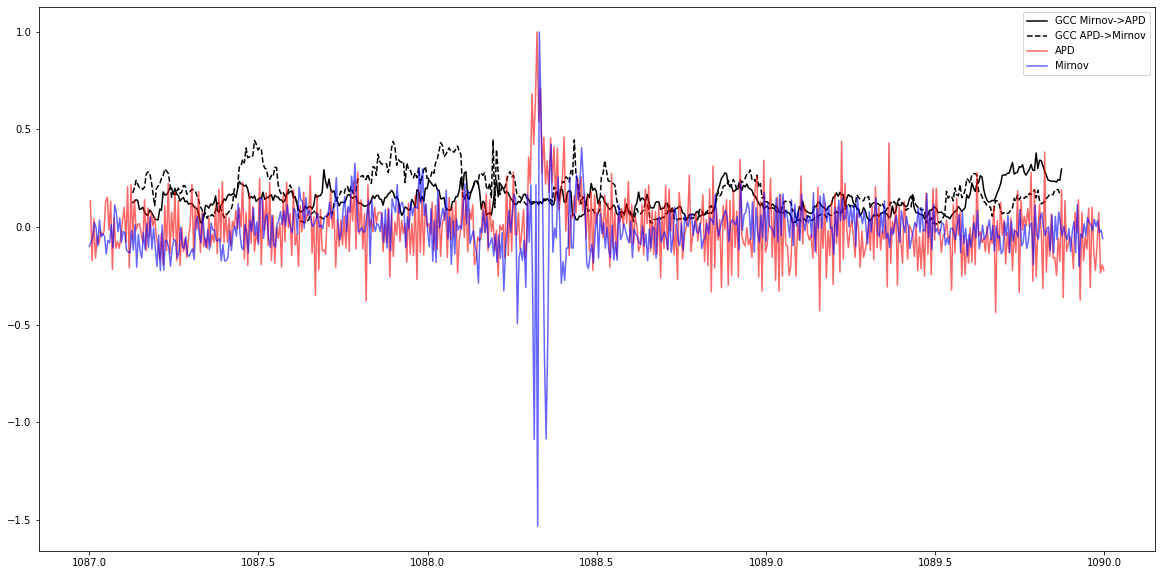

In [84]:
t_gcc = np.zeros(t_APD.size - WINDOW + 1)
sxy_gcc = np.zeros(t_gcc.shape)
syx_gcc = np.zeros(t_gcc.shape)

for i, _ in enumerate(t_gcc):
    t_gcc[i] = t_APD[i+int((WINDOW-1)/2)]

    x = s_APD[i:i+WINDOW]
    y = s_Mirnov[i:i+WINDOW]

    sxy_gcc[i] = get_gcc(x, y)
    syx_gcc[i] = get_gcc(y, x)

plt.figure(figsize=(20, 10))
plt.plot(t_gcc, sxy_gcc, c='k', label='GCC Mirnov->APD')
plt.plot(t_gcc, syx_gcc, 'k--', label='GCC APD->Mirnov')
plt.plot(t_APD, s_APD, c='r', alpha=.6, label='APD')
plt.plot(t_Mirnov, s_Mirnov, c='b', alpha=.6, label='Mirnov')
plt.legend()

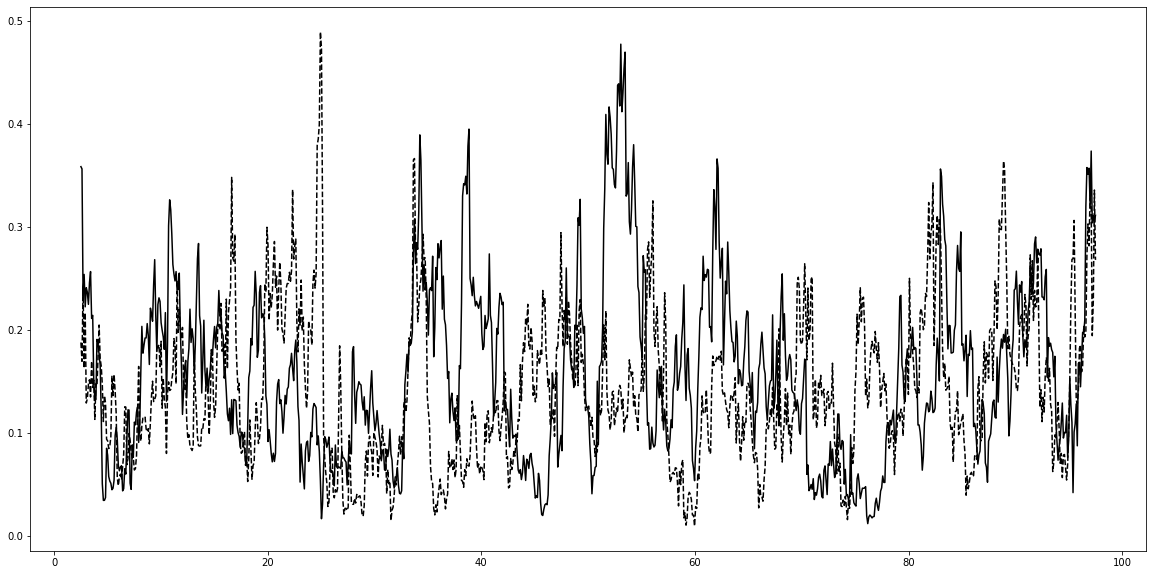

In [91]:
t = np.linspace(0, 100, 1000)
x = 2*np.sin(t) + np.random.rand(1000)
y = 0*np.sin(t-0.4) + np.random.rand(1000)



t_gcc = np.zeros(t.size - WINDOW + 1)
sxy_gcc = np.zeros(t_gcc.shape)
syx_gcc = np.zeros(t_gcc.shape)

for i, _ in enumerate(t_gcc):
    t_gcc[i] = t[i+int((WINDOW-1)/2)]

    _x = x[i:i+WINDOW]
    _y = y[i:i+WINDOW]

    sxy_gcc[i] = get_gcc(_x, _y)
    syx_gcc[i] = get_gcc(_y, _x)

plt.figure(figsize=(20, 10))
plt.plot(t_gcc, sxy_gcc, c='k')
plt.plot(t_gcc, syx_gcc, 'k--')


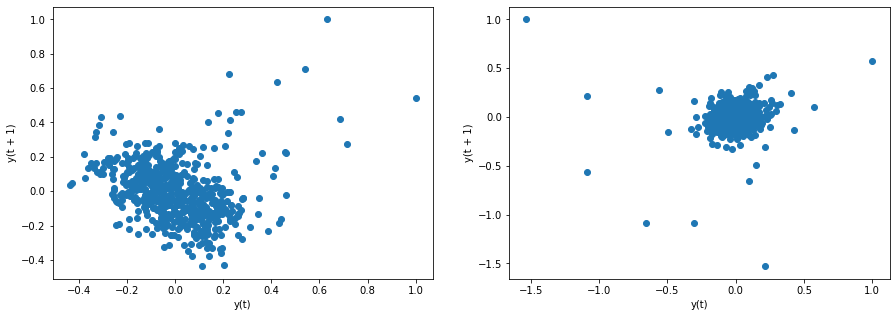

In [99]:
import pandas as pd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

pd.plotting.lag_plot(pd.Series(s_APD), ax=ax1)
pd.plotting.lag_plot(pd.Series(s_Mirnov), ax=ax2)

In [131]:
# Constants
N_SHOT = 17269
T_START = 1087
T_END = 1090

CHANNEL_APD = 14

# Load the relevant signals
shot = cdbxr.Shot(N_SHOT)
data=pd.DataFrame({
    'time': shot['APD.light_profile'].sel(time=slice(T_START, T_END)).time,
    'APD': detrend(shot['APD.light_profile'].sel(time=slice(T_START, T_END)).isel(R=CHANNEL_APD).data, type='constant'),
    'Mirnov': shot['Mirnov_A_rad_02_RAW'].sel(time=slice(T_START, T_END)).data[:-1:10]
})


In [135]:
rawData = data.copy(deep=True)
data['APD'] = data['APD'] - data['APD'].shift(1)
data['Mirnov'] = data['Mirnov'] - data['Mirnov'].shift(1)
data = data.dropna()

In [136]:
# split data into train and test. We will need this later for VAR analysis
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]

In [138]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary
from statsmodels.tsa.stattools import adfuller

X1 = np.array(data['APD'])
X1 = X1[~np.isnan(X1)]

result = adfuller(X1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
X2 = np.array(data['Mirnov'])
X2 = X2[~np.isnan(X2)]

result = adfuller(X2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -7.056806
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569
ADF Statistic: -7.534383
p-value: 0.000000
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.569


In [139]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(X1)
kpss_test(X2)

KPSS Statistic: 0.03139363769129416
p-value: 0.1
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.021590611224186113
p-value: 0.1
num lags: 19
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


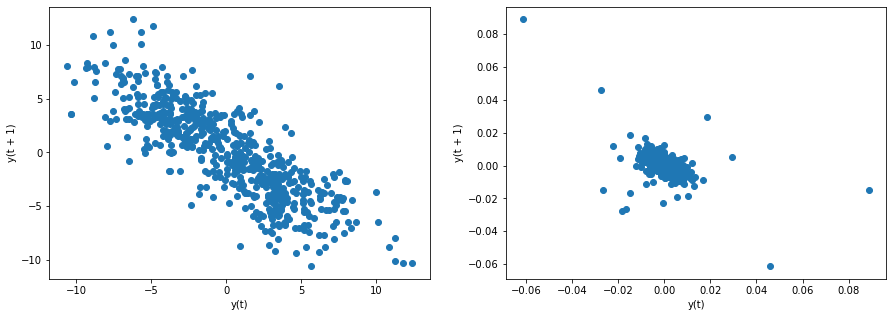

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

pd.plotting.lag_plot(data['APD'], ax=ax1)
pd.plotting.lag_plot(data['Mirnov'], ax=ax2)

In [143]:
rawData = rawData.dropna()
model = VAR(rawData) #recall that rawData is w/o difference operation
for i in range(1, 12):
    result = model.fit(i)
    try:
        print('Lag Order =', i)
        print('AIC : ', result.aic)
        print('BIC : ', result.bic)
        print('FPE : ', result.fpe)
        print('HQIC: ', result.hqic, '\n')
    except:
        continue

Lag Order = 1
AIC :  -64.48510191238522
BIC :  -64.39704992711413
FPE :  9.87361828038338e-29
HQIC:  -64.45082248637422 

Lag Order = 2
AIC :  -65.72692113779853
BIC :  -65.57263116148923
FPE :  2.852083463970565e-29
HQIC:  -65.66685017819424 

Lag Order = 3
AIC :  -67.33415460695561
BIC :  -67.11345525452381
FPE :  5.716790714267316e-30
HQIC:  -67.24822151739396 

Lag Order = 4
AIC :  -69.51056890476845
BIC :  -69.22328805574908
FPE :  6.485635049654266e-31
HQIC:  -69.39870277960217 

Lag Order = 5
AIC :  -65.65636605724637
BIC :  -65.30233085142085
FPE :  3.060690507524733e-29
HQIC:  -65.51849567969086 

Lag Order = 6
AIC :  -66.06430495319876
BIC :  -65.64334178618921
FPE :  2.0354730260687007e-29
HQIC:  -65.90035879346384 

Lag Order = 7
AIC :  -67.8069306737416
BIC :  -67.31886519257154
FPE :  3.563432714573577e-30
HQIC:  -67.61683688714902 

Lag Order = 8
AIC :  -65.54256727217893
BIC :  -64.98722437080004
FPE :  3.429968943634635e-29
HQIC:  -65.32625369726557 

Lag Order = 9
AIC